# Unsupervised Nearest Neighbors Kullanarak Collaborative Book Recommendation  

NearestNeighbors implements unsupervised nearest neighbors learning. It acts as a uniform interface to three different nearest neighbors algorithms: BallTree, KDTree, and a brute-force algorithm based on routines in sklearn.metrics.pairwise.


The most naive neighbor search implementation involves the brute-force computation of distances between all pairs of points in the dataset: for  samples in  dimensions, this approach scales as O[D N^2].

Efficient brute-force neighbors searches can be very competitive for small data samples. However, as the number of samples  grows, the brute-force approach quickly becomes infeasible


## Kaynaklar

- https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors
- https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms
- https://www.kaggle.com/sankha1998/collaborative-book-recommendation-system/data
- https://www.kaggle.com/ruchi798/book-crossing-starter-notebook-and-eda


## TODO

- gorsellestirme ekle (cesitli notebooklardan)
- detayli veri on isleme ekle
- pandas ve np API'sini iyi anla
- implicit ratinglerden bahset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# sutunlarin isimlerini liste ile belirle
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('../../data/book_x/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books
b_cols = ['ISBN', 'title' ,'author','year', 'publisher', 'img_s', 'img_m', 'img_l']
books = pd.read_csv('../../data/book_x/BX_Books.csv', sep=';', names=b_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['user_id', 'ISBN', 'rating']
ratings = pd.read_csv('../../data/book_x/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [3]:
users.head()

,user_id,location,age
0,User-ID,Location,Age
1,1,"nyc, new york, usa",NaN
2,2,"stockton, california, usa",18
3,3,"moscow, yukon territory, russia",NaN
4,4,"porto, v.n.gaia, portugal",17


In [4]:
# ise yaramayacak sutunlari at
books = books[['ISBN', 'title', 'author', 'year', 'publisher']] #feature engineering : selecting features
books.head()

,ISBN,title,author,year,publisher
0,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux


In [5]:
ratings.head()

,user_id,ISBN,rating
0,User-ID,ISBN,Book-Rating
1,276725,034545104X,0
2,276726,0155061224,5
3,276727,0446520802,0
4,276729,052165615X,3


In [6]:
print("book dataframe'i bicimi", books.shape)
print("users dataframe'i bicimi", users.shape)
print("ratings dataframe'i bicimi", ratings.shape)

book dataframe'i bicimi (271380, 5)
users dataframe'i bicimi (278859, 3)
ratings dataframe'i bicimi (1149781, 3)


In [7]:
# degerlendirme yapan ozgun kullinici sayisi
ratings['user_id'].value_counts().shape

(105284,)

In [8]:
# 200 degeri bruteforce da n^2 (polinomial) arttigi icin selected_ratings'i cok arttirmak akillica degil
# yada farkli bir algoritma kullanmak gerekli

selected_ratings = ratings['user_id'].value_counts() > 10
selected_ratings[selected_ratings].shape

(12053,)

In [9]:
selected_rating_index = selected_ratings[selected_ratings].index

In [10]:
selected_rating_index

Index(['11676', '198711', '153662', '98391', '35859', '212898', '278418',
       '76352', '110973', '235105',
       ...
       '222540', '57247', '144602', '181084', '31712', '26751', '83971',
       '114802', '227392', '4570'],
      dtype='object', length=12053)

In [11]:
# ratingsleri selectred ratingslere gore flitrele
ratings = ratings[ratings['user_id'].isin(selected_rating_index)]
print(ratings.shape)

(955273, 3)


In [12]:
# books ile ratings dataframelerini birlerstir

ratings_with_books = ratings.merge(books,on = 'ISBN')
print(ratings_with_books.shape)
# print(rating_with_books.head())

(867999, 7)


In [13]:
# pandas kisimlarini anla
# kitabin toplam rating sayisi
number_rating = ratings_with_books.groupby('title')['rating'].count().reset_index()
# sutunu yeni anlamina gore isimlendir
number_rating.rename(columns={'rating':'number of rating'}, inplace = True)
number_rating.head()

,title,number of rating
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [14]:
final_ratings = ratings_with_books.merge(number_rating,on = 'title')
final_ratings.head()
print(final_ratings.shape)

(867999, 8)


In [15]:
## 50 den fazla rating yapilan kitaplari kullan 
final_ratings = final_ratings[final_ratings['number of rating'] >= 30]
print(final_ratings.shape)
final_ratings.head()

(276310, 8)


,user_id,ISBN,rating,title,author,year,publisher,number of rating
14,276762,0380711524,5,See Jane Run,Joy Fielding,1992,Avon,46
15,6871,0380711524,0,See Jane Run,Joy Fielding,1992,Avon,46
16,7158,0380711524,0,See Jane Run,Joy Fielding,1992,Avon,46
17,12619,0380711524,5,See Jane Run,Joy Fielding,1992,Avon,46
18,23768,0380711524,0,See Jane Run,Joy Fielding,1992,Avon,46


In [16]:
# mukerrer kayitlari sil
final_ratings.drop_duplicates(['user_id', 'title'], inplace = True)
final_ratings.shape
# final_ratings
# final_ratings.info(verbose=True)

(272729, 8)

In [17]:
# pivot tablo olustur
# rating uzerinden aggraget et
final_ratings['rating'] = final_ratings['rating'].astype(int)
# final_ratings.info(verbose=True)
book_pivot = final_ratings.pivot_table(columns='user_id', index='title', values='rating') 

In [18]:
final_ratings.head()

,user_id,ISBN,rating,title,author,year,publisher,number of rating
14,276762,0380711524,5,See Jane Run,Joy Fielding,1992,Avon,46
15,6871,0380711524,0,See Jane Run,Joy Fielding,1992,Avon,46
16,7158,0380711524,0,See Jane Run,Joy Fielding,1992,Avon,46
17,12619,0380711524,5,See Jane Run,Joy Fielding,1992,Avon,46
18,23768,0380711524,0,See Jane Run,Joy Fielding,1992,Avon,46


In [19]:
book_pivot.shape

(3766, 10985)

In [20]:
book_pivot.fillna(0,inplace=True)

In [21]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

book_sparse = csr_matrix(book_pivot)
nn = NearestNeighbors(algorithm='brute')
nn.fit(book_sparse)

NearestNeighbors(algorithm='brute')

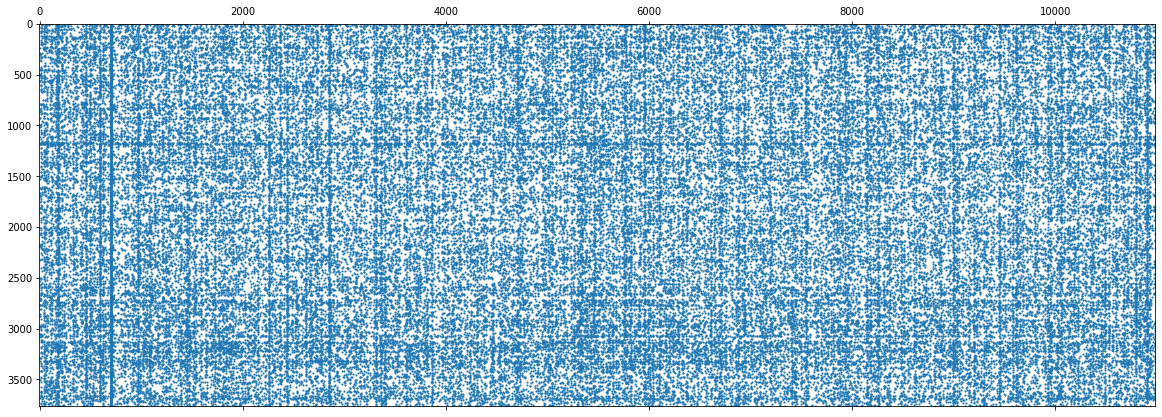

In [22]:
plt.figure(figsize=(20, 20))
plt.spy(book_sparse, markersize=1)

## Recommendation Function

In [23]:
def recommendation(book_name):
    book_id = np.where(book_pivot.index == book_name)[0][0]
    # buradaki olayi anla
    distances, suggestions = nn.kneighbors(
        book_pivot.iloc[book_id, :].values.reshape(1,-1)
    )    
    print("recommendation for ", book_name, "are: ")
    for ind, recommended in enumerate(book_pivot.index[suggestions[0]].values[1:]):
        print(recommended, "\ndst: ", distances[0][1:][ind])
    print()


In [24]:
# recommendation('White Teeth: A Novel')
# recommendation('Pleading Guilty')
# recommendation('American Gods')

recommendation('Animal Farm')
recommendation('The Fellowship of the Ring (The Lord of the Rings, Part 1)')
recommendation("Harry Potter and the Sorcerer's Stone (Book 1)")
recommendation("Harry Potter and the Chamber of Secrets (Book 2)")
recommendation("The Da Vinci Code")

# print(recommendation("Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"))

recommendation for  Animal Farm are: 
Unnatural Causes 
dst:  78.70196947980399
People Like Us 
dst:  79.16438593205912
Red Square 
dst:  79.18333157931662
The Road Ahead 
dst:  79.27799190191436

recommendation for  The Fellowship of the Ring (The Lord of the Rings, Part 1) are: 
The Two Towers (The Lord of the Rings, Part 2) 
dst:  100.00499987500625
The Return of the King (The Lord of the Rings, Part 3) 
dst:  100.93562304756433
Dream a Little Dream 
dst:  108.84392495679306
Daybreak 
dst:  109.02751946183129

recommendation for  Harry Potter and the Sorcerer's Stone (Book 1) are: 
Falling Backwards 
dst:  101.4741346353838
First Among Equals 
dst:  101.81846590869458
The Beast from the East (Goosebumps, No 43) 
dst:  101.84301645179212
People Like Us 
dst:  101.86756107809786

recommendation for  Harry Potter and the Chamber of Secrets (Book 2) are: 
Harry Potter and the Goblet of Fire (Book 4) 
dst:  124.370414488334
Harry Potter and the Prisoner of Azkaban (Book 3) 
dst:  124.615